# Wetting and drying approach for DG-CG

Currently, the DG-CG code can produce instabilities in certain scenarios involving wetting and drying.

In [18]:
from utils_beach import *
from IPython.display import HTML

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Overview
The current approach is this:

For each time step:
1. Compute elevation with DG, applying the DG wet/dry algorithm to elemental `WDFLG`
2. Project DG elevation to CG
3. Call ADCIRC wet/dry routine, which sets both nodal and elemental flags `NODECODE` and `NOFF`
4. Set `NOFF = WDFLG`
5. Solve for momentum with CG

Additionally, in the DG solver we permit flux coming from dry to wet element (see the island test case below for motivation). We only forbid numerical flux between dry elements.

## Small island test case

This is located in `continuity_tests/island`. This test case is extracted from a larger "coarse mesh", and contains several islands with partially wet elements near their boundaries. 

### Still water scenario

In this scenario, all outer boundaries are land (zero normal flux), and velocities at all points should be zero.


<img src="./island/still_mesh.jpg" width="300"/>

```{image} ./island/still_mesh.jpg
:class: bg-primary mb-1
:width: 300px
```

Applying the previous version of DG-CG results in an unstable simulation due to nonzero velocity being propagated from elements near the islands. Further investigation shows that this is due to small differences between the interfaces which cause the numerical flux to be nonzero. This is resolved by setting a tolerance value (currently $1 \times 10^{-8}$ m) for the difference in water elevation at the two faces, below which the two values are considered identical.

### Ocean boundary scenario

Here we have a periodic elevation boundary on the right side.


<img src="./island/open_mesh.jpg" width="300"/>

```{image} ./island/open_mesh.jpg
:width: 300px
```

The issue seems to be that, for some elements connected to both wet and dry nodes, the numerical flux is not correctly computed and that causes incorrect elevation gradient, amplifying the velocities in the subsequent time steps. This is somewhat demonstrated by commenting out the section in `internal_edge_hydro.F`:

```fortran
if (abs(f_hat).gt.1.d-12) then
   !
   if (wdflg(el_in).eq.0) then
      ! el_in is dry !
      if (f_hat.gt.0) then
         ! flux going from the dry element (in)
         ! on the wet side (ex): reflect boundary
         cycle
      endif

   elseif (wdflg(el_ex).eq.0) then

      ! el_ex is dry
      if (f_hat.lt.0) then
         ! flux comming from dry size (ex)
         ! on the wet side (in): reflect boundary
         cycle
      endif
   endif
endif
```

This code snippet essentially forbids a mass flux coming from a dry element. The problem is that we don't have a corresponding the handling of numerical flux for momentum (we're letting ADCIRC handle momentum), so this may be an incorrect formulation. Commenting out this section produces a more stable result, but it may allow negative water depths in other problems (since the outgoing flux may be enough to dry out the element). An idea from Leveque is to use HLL flux which preserves positivity of water depth, but that will probably have to be adjusted for the DG method.


Without this correction, run:

    make noflux

to run the program with the option `--disable_flux`.

In [ ]:
tr = read_triangulation('island/fort.14')
total_nodes = len(tr.x)
node_list = list(range(1, total_nodes+1))

d1 = read_63('island/fort.63.noflux', nodes=node_list, total_nodes=total_nodes)
d2 = read_63('island/fort.63.adc', nodes=node_list, total_nodes=total_nodes)
data = [
        ('DG-CG, no mass flux from dry to wet', d1), 
        ('ADCIRC', d2)
]
ani = animate_mesh(tr, data, vmin=-.5, vmax=.5, frameskip=5)
HTML(ani.to_jshtml())

With this correction, the code becomes more stable, although there are some artifacts near the wet/dry region. We can run this case with 

    make coupling-serial

to generate the DG-CG solution with this fix, respectively.

In [ ]:
tr = read_triangulation('island/fort.14')
total_nodes = len(tr.x)
node_list = list(range(1, total_nodes+1))

d1 = read_63('island/fort.63.coupling', nodes=node_list, total_nodes=total_nodes)
d2 = read_63('island/fort.63.adc', nodes=node_list, total_nodes=total_nodes)
data = [
        ('DG-CG', d1), 
        ('ADCIRC', d2)
]
ani = animate_mesh(tr, data, vmin=-.5, vmax=.5, frameskip=5)
HTML(ani.to_jshtml())

## Coarse mesh

This case is a coarse mesh for the gulf of mexico, generated using OceanMesh2D. It contains around 160k nodes, and is the superset of the island test case.

<img src="./coarse/mesh.jpg" width="400"/>

```{image} ./coarse/mesh.jpg
:width: 400px
```

### Tides only

In [ ]:
tr = read_triangulation('coarse/fort.14')
total_nodes = len(tr.x)
node_list = list(range(1, total_nodes+1))

d1 = read_63('coarse/fort.63.save', nodes=node_list, total_nodes=total_nodes)
d2 = read_63('coarse/fort.63.adc', nodes=node_list, total_nodes=total_nodes)

#d2 = read_63_nc('coarse/fort.63.adc.nc')
data = [
        ('DG-CG', d1), 
        ('ADCIRC', d2)
]

ani = animate_mesh(tr, data, plot_grid=False, vmin=-1, vmax=2, frameskip=2)
HTML(ani.to_jshtml())

### Hurricane Ike
This case fails about 1 day in the simulation due to velocity blowing up, again near land/island boundaries with sharp bathymetry. We will try simply lowering the bathymetry of these problematic spots to avoid having to do wetting/drying at all.

In [ ]:
tr = read_triangulation('coarse_ike/fort.14')
total_nodes = len(tr.x)
node_list = list(range(1, total_nodes+1))

d1 = read_63('coarse_ike/fort.63.save', nodes=node_list, total_nodes=total_nodes)
#d2 = read_63('coarse_ike/fort.63.adc', nodes=node_list, total_nodes=total_nodes)
d2 = read_63('coarse_ike/fort.63.noflux', nodes=node_list, total_nodes=total_nodes)

#d2 = read_63_nc('coarse/fort.63.adc.nc')
data = [
        ('DG-CG', d1), 
        ('DG-CG, no flux', d2)
]

ani = animate_mesh(tr, data, plot_grid=False, vmin=-1, vmax=3, frameskip=1)
HTML(ani.to_jshtml())

In [23]:
tr = read_triangulation('ike_small/fort.14')
total_nodes = len(tr.x)
node_list = list(range(1, total_nodes+1))

d1 = read_63('ike_small/fort.63.coupling', nodes=node_list, total_nodes=total_nodes)
#d2 = read_63('coarse_ike/fort.63.adc', nodes=node_list, total_nodes=total_nodes)
#d2 = read_63('coarse_ike/fort.63.noflux', nodes=node_list, total_nodes=total_nodes)

#d2 = read_63_nc('coarse/fort.63.adc.nc')
print("Finished loading data")

Finished loading data


In [31]:
data = [
        ('DG-CG', d1), 
        #('DG-CG, no flux', d2)
]

ani = animate_mesh(tr, data, plot_grid=False, vmin=-2, vmax=3, frameskip=10, extent=(-95.4,-95.1,28.8,29.1))
#ani = animate_mesh(tr, data, plot_grid=False, vmin=-2, vmax=3, frameskip=10, extent=None)

HTML(ani.to_jshtml())

### Noflux case
We encounter NaNs from numerical flux around -95.27, 28.91.

In [26]:
tr,_ = read_triangulation('ike_small/fort.14')
total_nodes = len(tr.x)
node_list = list(range(1, total_nodes+1))

d1 = read_63('ike_small/fort.63.noflux', nodes=node_list, total_nodes=total_nodes)
#d2 = read_63('coarse_ike/fort.63.adc', nodes=node_list, total_nodes=total_nodes)
#d2 = read_63('coarse_ike/fort.63.noflux', nodes=node_list, total_nodes=total_nodes)

#d2 = read_63_nc('coarse/fort.63.adc.nc')
print("Finished loading data")

Finished loading data


In [ ]:
data = [
        ('DG-CG', d1), 
        #('DG-CG, no flux', d2)
]

#ani = animate_mesh(tr, data, plot_grid=False, vmin=-2, vmax=3, frameskip=10, extent=(-95.4,-95.1,28.8,29.1))
ani = animate_mesh(tr, data, plot_grid=False, vmin=-2, vmax=3, frameskip=5, extent=None)

HTML(ani.to_jshtml())

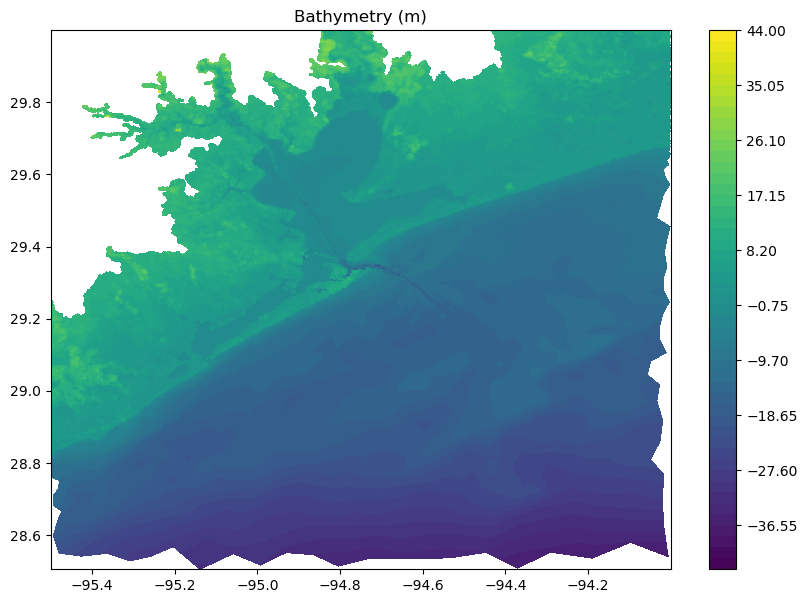

In [25]:
fig = plot_bathy('ike_small/fort.14')

In [12]:
bathy.shape

(134744,)